# Section 1: Simulate from various task (using the existing modules to set up).
used modules: `task`, `agent`, `dataset`

Goal: to simulate for any task and agents and store the results in the dataset. (No training/RT modelling is done)

In [20]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
import config as co
from utils import *  # get_current_file_name, goto_root_dir
import pprint

reload(ts)
pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()

In [17]:
action_bit =2
S = 8
for s in range(S): 
    sf = s ^ (1 << action_bit)
    print(f's:{s} sf:{sf} action_bit:{action_bit}')

s:0 sf:4 action_bit:2
s:1 sf:5 action_bit:2
s:2 sf:6 action_bit:2
s:3 sf:7 action_bit:2
s:4 sf:0 action_bit:2
s:5 sf:1 action_bit:2
s:6 sf:2 action_bit:2
s:7 sf:3 action_bit:2


In [26]:
def build_mirror_idx(N: int, device='cuda'):
    assert N % 2 == 0, "N must be even for symmetry"
    return (torch.arange(N, device = device) + N // 2) % N

In [28]:
build_mirror_idx(N = 100)

tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,  0,  1,  2,  3,
         4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49], device='cuda:0')

In [30]:
tens = torch.randn(3,4,5)

Docstring:
numel(input) -> int

Returns the total number of elements in the :attr:`input` tensor.

Args:
    input (Tensor): the input tensor.

Example::

    >>> a = torch.randn(1, 2, 3, 4, 5)
    >>> torch.numel(a)
    120
    >>> a = torch.zeros(4,4)
    >>> torch.numel(a)
    16
Type:      builtin_function_or_method

### Simulate an experiment:
- [ ] PRL: pure reversal learning, Li et al. task 1
    - deteministic transition $A_i$ to $S_i$  
- [ ] RTS: reversal two-stage, Li et al. task 2
    - probabilistic transition $A_i$ to $S_i$
- [ ] NTS: transition-reversal two-stage, Li et al. task 3
    - probabilistic trnasition + outer level reversal

Currently, no import is made and only random model parameters are taken. (fitted model directories are not available)

In [3]:
tasks = {
    # "PRL": ts.Two_step(com_prob=1),  # common transition always happens
    # "RTS": ts.Two_step(),
    # "NTS": ts.Two_step(rew_gen="trans_rev"),
    "walk": ts.Two_step(rew_gen="walks"),
}
N_blocks = 100
N_trials = 100
device = "cpu"
exp_folder = 0  #automatically generate this
seed = 0

In [6]:
# For now only consider RTS
agents = {}
config = {}
cog_types = ["MB0s", "LS0", "MB0", "MB1"]

for cog_type in cog_types:
    cog_config = co.sim_config_from_inputs(False, 
                                          agent_type="PRLCog", 
                                          cog_type=cog_type, 
                                          device=device, 
                                          seed=seed,
                                          num_blocks=N_blocks,
                                          num_trials=N_trials,
                                          exp_folder=0)
    config[f'walks_{cog_type}'] = cog_config
    agents[f'walks_{cog_type}'] = Agent(cog_config['agent_type'], config = cog_config)

In [45]:
cog_config

{'dataset': 'MillerRat',
 'behav_format': 'cog_session',
 'agent_type': 'PRLCog',
 'cog_type': 'MB1',
 'device': 'cpu',
 'outer_fold': 0,
 'inner_fold': 0,
 'seed': 0,
 'exp_folder': 'exp_simulated_Akam_PRL',
 'task': 'Akam_PRL',
 'com_prob': 1,
 'rew_gen': 'blocks',
 'block_length': 50,
 'rew_probs': [0.2, 0.8],
 'n_blocks': 100,
 'n_trials': 100,
 'sim_seed': 0,
 'sim_exp_name': 'simulated_Akam_PRL',
 'additional_name': '',
 'model_path': PosixPath('exp_simulated_Akam_PRL/cog_type-MB1/outerfold0_innerfold0_seed0')}

In [10]:
for cog_type in cog_types: 
    agents[f'walks_{cog_type}'].simulate(tasks["walk"], config[f'walks_{cog_type}'], save = True)
    
# Clearing all variables for clean environment

Simulating cog agent MB0s with params [0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent LS0 with params [0.1, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent MB0 with params [0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent MB1 with params [0.5, 0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 


In [2]:
# %reset -f
# Let's retrieve some data
# Working with PRL for now. Let's focus on PRL MB1 model
%load_ext autoreload
%autoreload 2
from path_settings import *
import joblib
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import CustomMapper.CustomMapper as c
import torch
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from agents.DynamicSystems import ISNNet
from agents.ComplexAgent import DynamicAgent

pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()
LS0_data = joblib.load(SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'LS0_seed0.pkl')
type(SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'MB1_seed0.pkl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-07-25 11:05:42.967102: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 11:05:42.976356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 11:05:42.989717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 11:05:42.989748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 11:05:42.998728: I tensorflow/core/platform/cpu_feature_gua

pathlib.PosixPath

In [3]:
# Trainer parameters
batch_size = 20
RTRNN_config = {
    "task": "PRL_Bartolo", 
    "dt": 0.02, # 0.02s time step, as in Jaffe et al. 
    "T": 200, # 1s upper for RT
    "n_blocks": 100,
    "cog_data": SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'LS0_seed0.pkl',
    "bias": 0.01, 
    "ndt_s": 0.01, 
    "ndt_mu": 0.1, 
    "driftscale": 2, 
    "redo_choices": False,
    "trainer_type": "RTRNNTrainer",
    "model_specs": {
        "model_name": "RTRNN", 
        "model_path": "Network_models.RTRNN",
        "model_params":{
            "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
            "cell_type":"GRU", "trial_output_hidden": 0, "trial_output_hidden_size": [], # if want hidden output layers (deep output, then give a list)
            "trial_output_hidden_nonlinearities": [], "pad_zeros":0, "last_step": False
        },
    },
    "rt_weight": 0.01,
    "device": "cuda", 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.0005,
        },
    },
    "training_config":{
        "task_id": "1.1",
        "task_config": {
            "task": "PRL_Bartolo",
        }
    },  
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": LOG_PATH, # These are to be modified when the big configs gets defined
}

# for agent in ["MB0s"]:#, "LS0", "MB0", "MB1"]:
#     RTRNN_config["cog_data"] = SIM_SAVE_PATH / 'simulated_Akam_PRL' / f'{agent}_seed0.pkl'
#     experiment = c.CustomMapper(RTRNN_config)
#     experiment.rt_model = "RELOAD"
#     pickle.dump(experiment, open(DATA_PATH/f"experiment_{agent}_1.pkl", "wb"))


In [4]:
# let's block train some models - for each model try: 
# GRU hidden size 8, 16
# recurrence_per_trial: 1, 2, 3
# zero padding, 0, 1
for agent in ["MB0s", "LS0", "MB0", "MB1"]:
    for hidden_size in [8, 16]:
        for zero_padding in [0, 1]:
            for recurrence_per_trial in [1, 2]:
                experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_1.pkl", "rb"))
                experiment.configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
                experiment.configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
                experiment.configs["model_specs"]["model_params"]["recurrence_per_trial"] = recurrence_per_trial
                experiment.initialise_dataloaders()
                experiment.initialise_trainer(experiment.configs)
                model_name = f"{agent}_GRU_HS={hidden_size}_N={recurrence_per_trial}_ZP{zero_padding}"
                for path in [experiment.configs["save_path"], experiment.configs["check_path"], experiment.configs["log_path"]]:
                    path = path / model_name 
                    if not os.path.exists(path):
                        os.makedirs(path)
                experiment.trainer.train(
                    experiment.dataloaders["train"],
                    experiment.dataloaders["val"],
                    epochs = 2000,
                    save_interval = 500,
                    reset_interval = 10000,
                    save_path = experiment.configs["save_path"] / model_name / "model.pth",
                    check_path = experiment.configs["check_path"] / model_name,
                    log_path = experiment.configs["log_path"] / model_name,
                    early_stop = 1000,
                )

tensor(0.6934, device='cuda:0')
tensor(0.6892, device='cuda:0')
tensor(0.6886, device='cuda:0')
tensor(0.6842, device='cuda:0')
tensor(0.6810, device='cuda:0')
tensor(0.6781, device='cuda:0')
tensor(0.6759, device='cuda:0')
tensor(0.6726, device='cuda:0')
tensor(0.6692, device='cuda:0')
tensor(0.6670, device='cuda:0')
tensor(0.6641, device='cuda:0')
tensor(0.6611, device='cuda:0')
tensor(0.6574, device='cuda:0')
tensor(0.6548, device='cuda:0')
tensor(0.6524, device='cuda:0')
tensor(0.6485, device='cuda:0')
tensor(0.6458, device='cuda:0')
tensor(0.6420, device='cuda:0')
tensor(0.6385, device='cuda:0')
tensor(0.6355, device='cuda:0')
tensor(0.6325, device='cuda:0')
tensor(0.6294, device='cuda:0')
tensor(0.6262, device='cuda:0')
tensor(0.6214, device='cuda:0')
tensor(0.6187, device='cuda:0')
tensor(0.6154, device='cuda:0')
tensor(0.6099, device='cuda:0')
tensor(0.6074, device='cuda:0')
tensor(0.6038, device='cuda:0')
tensor(0.5977, device='cuda:0')
tensor(0.5948, device='cuda:0')
tensor(0

KeyboardInterrupt: 

In [12]:
agent = "MB0s"
hidden_size = 16
zero_padding = 1
recurrence_per_trial = 4
experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_1.pkl", "rb"))
experiment.configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
experiment.configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
experiment.configs["model_specs"]["model_params"]["recurrence_per_trial"] = recurrence_per_trial
experiment.configs["model_specs"]["model_params"]["trial_output_hidden_size"] = [8]
experiment.configs["model_specs"]["model_params"]["trial_output_hidden_nonlinearities"] = ["ReLU"]
experiment.configs["model_specs"]["model_params"]["trial_output_hidden"] = 0
experiment.configs["model_specs"]["model_params"]["cell_type"] = "GRU"
experiment.configs["rt_weight"] = 0.5
experiment.initialise_dataloaders()
experiment.initialise_trainer(experiment.configs)
model_name = f"{agent}_RNN_HS={hidden_size}_N={recurrence_per_trial}_ZP{zero_padding}_experimental_5"
for path in [experiment.configs["save_path"], experiment.configs["check_path"], experiment.configs["log_path"]]:
    path = path / model_name 
    if not os.path.exists(path):
        os.makedirs(path)
experiment.trainer.train(
    experiment.dataloaders["train"],
    experiment.dataloaders["val"],
    epochs = 10000,
    save_interval = 500,
    reset_interval = 10000,
    save_path = experiment.configs["save_path"] / model_name / "model.pth",
    check_path = experiment.configs["check_path"] / model_name,
    log_path = experiment.configs["log_path"] / model_name,
    early_stop = 1000,
)

tensor(1.4341, device='cuda:0')
tensor(1.4002, device='cuda:0')
tensor(1.3673, device='cuda:0')
tensor(1.3348, device='cuda:0')
tensor(1.3027, device='cuda:0')
tensor(1.2712, device='cuda:0')
tensor(1.2397, device='cuda:0')
tensor(1.2077, device='cuda:0')
tensor(1.1760, device='cuda:0')
tensor(1.1441, device='cuda:0')
tensor(1.1119, device='cuda:0')
tensor(1.0793, device='cuda:0')
tensor(1.0474, device='cuda:0')
tensor(1.0147, device='cuda:0')
tensor(0.9825, device='cuda:0')
tensor(0.9499, device='cuda:0')
tensor(0.9191, device='cuda:0')
tensor(0.8881, device='cuda:0')
tensor(0.8594, device='cuda:0')
tensor(0.8335, device='cuda:0')
tensor(0.8093, device='cuda:0')
tensor(0.7891, device='cuda:0')
tensor(0.7718, device='cuda:0')
tensor(0.7583, device='cuda:0')
tensor(0.7471, device='cuda:0')
tensor(0.7391, device='cuda:0')
tensor(0.7340, device='cuda:0')
tensor(0.7294, device='cuda:0')
tensor(0.7264, device='cuda:0')
tensor(0.7226, device='cuda:0')
tensor(0.7197, device='cuda:0')
tensor(0

In [5]:
experiment = pickle.load(open(DATA_PATH/"experiment_LS0_1.pkl", "rb"))

# experiment.configs = RTRNN_config

# experiment._cog_data_frame()
# experiment.reload_RT_model()
# experiment.remap_data()

In [194]:
experiment.initialise_dataloaders()
experiment.initialise_trainer(RTRNN_config)

In [186]:
model_name = "RTRNN_db"
for path in [RTRNN_config["save_path"], RTRNN_config["check_path"], RTRNN_config["log_path"]]:
    path = path / model_name 
    if not os.path.exists(path):
        os.makedirs(path)
print(f"tensorboard --logdir={RTRNN_config['log_path']}")
experiment.trainer.train(
    experiment.dataloaders["train"],
    experiment.dataloaders["val"],
    epochs = 2000,
    save_interval = 100,
    reset_interval = 10000,
    save_path = RTRNN_config["save_path"] / model_name / "model.pth",
    check_path = RTRNN_config["check_path"] / model_name,
    log_path = RTRNN_config["log_path"] / model_name,
    early_stop = 1000,
)

tensorboard --logdir=../../logs


In [5]:
agent = "LS0"
experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_0.pkl", "rb"))
hidden = 16
recurrence = 1
zero_padding = 1
experiment.configs["model_specs"]["model_params"]["hidden_size"] = hidden
experiment.configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
experiment.configs["model_specs"]["model_params"]["recurrence_per_trial"] = recurrence
experiment.initialise_trainer(experiment.configs)
# experiment.trainer.load_model(experiment.configs["save_path"] / f"{agent}_GRU_HS={hidden}_N={recurrence}_ZP{zero_padding}" / "model.pth")

In [9]:
experiment.trainer.load_model(experiment.configs["save_path"]/
                                f"{agent}_RNN_HS={hidden_size}_N={recurrence}_ZP{zero_padding}_experimental_5" / "model.pth")

In [13]:
u = experiment.dataloaders["val"].dataset.u
experiment.trainer.model.eval()
with torch.no_grad():
    u = u.to(experiment.trainer.device).float()
    h, out = experiment.trainer.model.show(u)

In [17]:
recurrence = 4
import plotly.express as px
# scatter plot with line connecting each point
lines = pd.DataFrame(h[0, :, :8].cpu().numpy())
x = np.linspace(0, 100 * recurrence - 1, 100 * recurrence) 
lines["x"] = x
lines = lines.melt(id_vars = "x", var_name = "h_dim", value_name = "h_value")
px.line(lines, x = "x", y = "h_value", color = "h_dim")


In [32]:
h.shape
import plotly.express as px
# scatter plot with line connecting each point
lines = pd.DataFrame(h[0, :, :8].cpu().numpy())
x = np.linspace(0, 99, 100) if recurrence == 1 else np.linspace(0, 199, 200)
lines["x"] = x
lines = lines.melt(id_vars = "x", var_name = "h_dim", value_name = "h_value")
px.line(lines, x = "x", y = "h_value", color = "h_dim")


In [18]:
block_id = 0
choices = pd.DataFrame(out[block_id, :, :].cpu().numpy())
choices.columns = ["predicted_choice", "predicted_rt (log)"]
x = np.linspace(0, 99, 100)

choices["x"] = x
choices["true_choice"] = experiment.dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
true_z = -np.array([list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][0] -  list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][1] for i in range(100)])
true_z = (true_z - min(true_z))/(max(true_z) - min(true_z))
choices["true_z"] = true_z
choices["true_rt (log)"] = np.log(experiment.dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy())
true_median_rt = experiment.cog_data["median_RTs"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id]
choices["true_median_rt (log)"] = np.array(np.log(true_median_rt))

choices = choices.melt(id_vars = "x", var_name = "choice", value_name = "choice_value")
px.line(choices, x = "x", y = "choice_value", color = "choice")

/tmp/ipykernel_278880/2922346751.py:11: RuntimeWarning:

invalid value encountered in log



In [33]:
block_id = 0
choices = pd.DataFrame(out[block_id, :, :].cpu().numpy())
choices.columns = ["predicted_choice", "predicted_rt (log)"]
x = np.linspace(0, 99, 100)

choices["x"] = x
choices["true_choice"] = experiment.dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
true_z = -np.array([list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][0] -  list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][1] for i in range(100)])
true_z = (true_z - min(true_z))/(max(true_z) - min(true_z))
choices["true_z"] = true_z
choices["true_rt (log)"] = np.log(experiment.dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy())
true_median_rt = experiment.cog_data["median_RTs"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id]
choices["true_median_rt (log)"] = np.array(np.log(true_median_rt))

choices = choices.melt(id_vars = "x", var_name = "choice", value_name = "choice_value")
px.line(choices, x = "x", y = "choice_value", color = "choice")

/tmp/ipykernel_14744/2922346751.py:11: RuntimeWarning:

invalid value encountered in log



In [222]:
# let's now barplot the performance of these models over simulated datasets: 
rt_performance = {}
choice_performance = {}
for agent in ["MB0s", "LS0", "MB0", "MB1"]:
    for hidden_size in [8, 16]:
        for zero_padding in [0, 1]:
            for recurrence_per_trial in [1, 2]:
                experiment = pickle.load(open(DATA_PATH/f"experiment_{agent}_0.pkl", "rb"))
                experiment.configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
                experiment.configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
                experiment.configs["model_specs"]["model_params"]["recurrence_per_trial"] = recurrence_per_trial
                experiment.initialise_dataloaders()
                experiment.initialise_trainer(experiment.configs)
                model_name = f"{agent}_GRU_HS={hidden_size}_N={recurrence_per_trial}_ZP{zero_padding}"
                experiment.trainer.load_model(experiment.configs["save_path"] / model_name / "model.pth")
                rt_loss, choice_loss = experiment.evaluate()
                rt_performance[model_name] = np.pad(rt_loss[0], (0, 2000 - len(rt_loss[0])), 'constant', constant_values = np.nan)
                choice_performance[model_name] = np.pad(choice_loss[0], (0, 2000 - len(choice_loss[0])), 'constant', constant_values = np.nan)


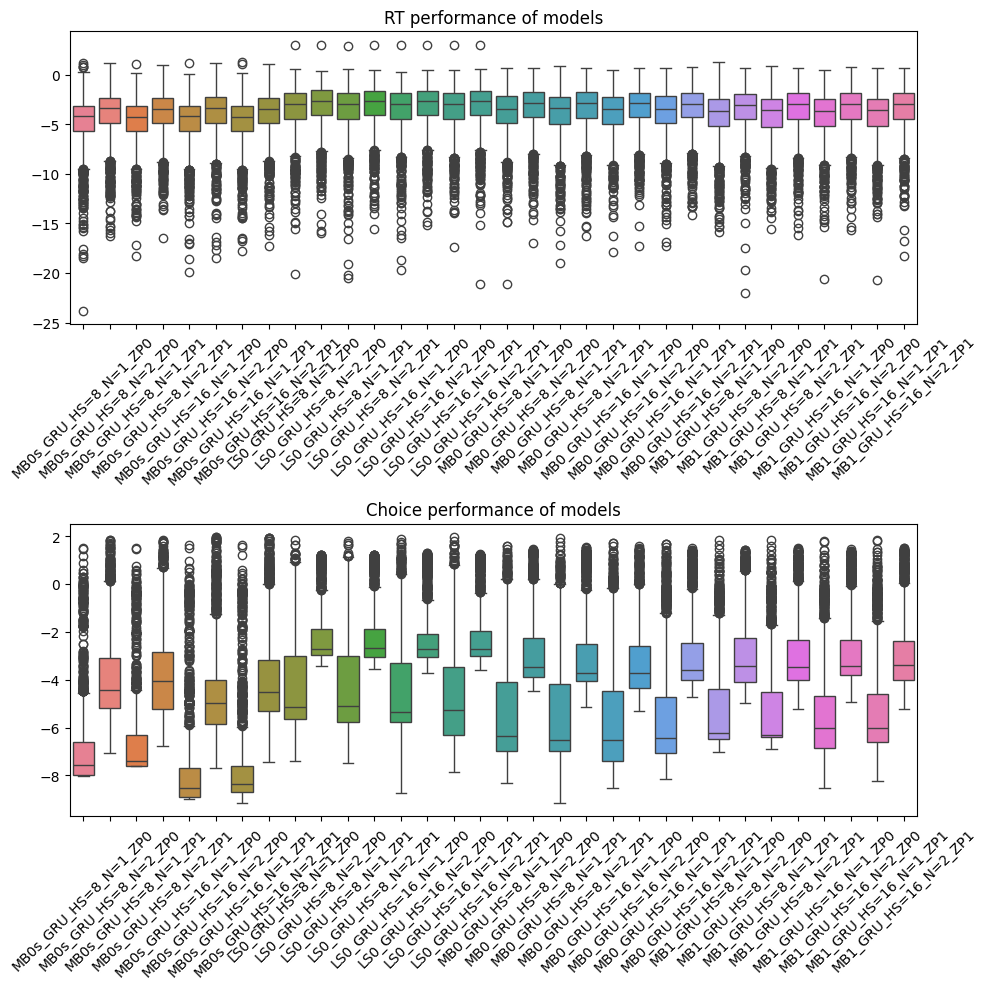

In [243]:
# plot boxplots, though each key from the dictionary has a different length
rt_performance = pd.DataFrame(rt_performance)
choice_performance = pd.DataFrame(choice_performance)
# plot boxplots with sns
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
sns.boxplot(data = np.log(rt_performance), ax = ax[0])
ax[0].set_xticks(ticks = np.arange(len(rt_performance.columns)),
                 labels = rt_performance.columns, rotation=45)
ax[0].set_title("RT performance of models")
sns.boxplot(data = np.log(choice_performance), ax = ax[1])
ax[1].set_xticks(ticks = np.arange(len(rt_performance.columns)),
                 labels = rt_performance.columns, rotation=45)
ax[1].set_title("Choice performance of models")
plt.tight_layout()

# MOVE TO REAL DATA

In [3]:
import time
current_time = time.time()
print(f"start sampling 1 point: {current_time}")
solution1 = experiment.rt_model.solve(
    {"strength_A": 0.12, "strength_B": 0.38}
).sample(k = 1)
end_time = time.time()
print(f"end sampling 1 point: {end_time}, took {end_time - current_time} seconds")

current_time = time.time()
print(f"start sampling 100 points: {current_time}")
solution2 = experiment.rt_model.solve(
    {"strength_A": 5 * 0.12, "strength_B": 5 * .38}
).sample(k = 10000)
end_time = time.time()
print(f"end sampling 100 points: {end_time}, took {end_time - current_time} seconds")

start sampling 1 point: 1737490891.0761316


NameError: name 'experiment' is not defined

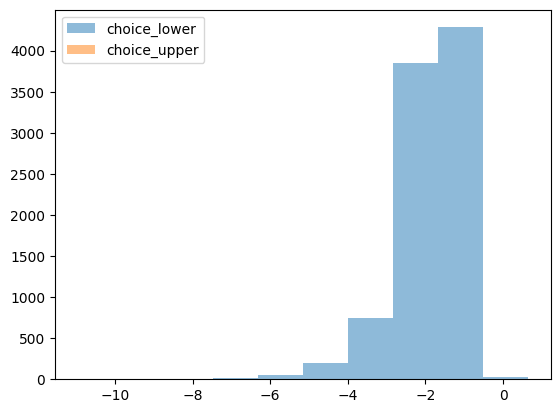

In [91]:
cutoff = 2
lower = np.array([l if l < cutoff else np.nan for l in solution2.choice_lower])
upper = np.array([l if l < cutoff else np.nan for l in solution2.choice_upper])
plt.hist(np.log(lower), 
bins = 10, alpha = 0.5, label = "choice_lower")
plt.hist(np.log(upper),
bins = 10, alpha = 0.5, label = "choice_upper")
plt.legend()

In [92]:
print(np.median(np.log(lower[~np.isnan(lower)])))
print(np.median(upper[~np.isnan(upper)]))

-1.7265100242580895
0.799730018096533


# Experimentation with a more complex network

In [1]:
%load_ext autoreload
%autoreload 2
from path_settings import *
from Network_models.Trainer import DynAgentTrainer
DynConfigs = {
    "model_name": "ISNNet",
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": LOG_PATH,
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "DynamicAgent", 
        "model_path": "agents.ComplexAgent",
        "model_params": {
            "net_type": "ISNNet", 
            "net_config": {},
            "trial_length": 1000, 
            "N": 10, 
            "out_dim": 1, 
            "in_dim": 3, 
            "hidden_dim": 32,
        }
    },
    "device": "cuda", 
    "scheduler": False, 
    # "scheduler": {
    #     "name": "ReduceLROnPlateau",
    #     "params": {
    #         "mode": "min",
    #         "factor": 0.1,
    #         "patience": 100,
    #         "min_lr": 5e-4,
    #         "cooldown": 50, 
    #     },
    # }, 
    "training_config": {
        "batch_size": 256, 
        "val_ratio": 0.2, 
        "n_trials": 100, 
    }, 
    "loss_config": {
        "loss_compound_func_package": "utils.loss_helpers", 
        "loss_compound_func": "interpolate_exp",
        "weight_regularisation_weight": 0.00, 
        "output_norm_weight": 0.00, 
        "input_norm_weight": 0.00
    }, 
    "task_module": "tasks.akam_tasks",
    "task": "Two_step_torch",
    "task_config": {
        "rew_gen": "blocks",
    }
}

trainer = DynAgentTrainer(DynConfigs)


2025-07-14 10:45:35.955681: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 10:45:36.033852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 10:45:36.074499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 10:45:36.074753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 10:45:36.131403: I tensorflow/core/platform/cpu_feature_gua

In [185]:
model_name = "ISNNet_I_on_5"
os.makedirs(MODEL_SAVE_PATH / model_name, exist_ok = True)
trainer.train(epochs = 50, 
              save_interval = 10, 
              reset_interval = 1000, 
              early_stop = 1000, 
              save_path=MODEL_SAVE_PATH / model_name / "model.pth",
              check_path=MODEL_SAVE_PATH / model_name,
              log_path=LOG_PATH / model_name)

Epoch 0


/home/timmy/projects/Tiny_RNN_RT/codes/Codes/agents/ComplexAgent.py:92: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:156: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:161: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:167: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

Loss: 11.78722095489502


/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:151: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1
Loss: 11.488340377807617
Epoch 2
Loss: 11.114890098571777
Epoch 3
Loss: 10.784337043762207
Epoch 4
Loss: 10.874017715454102
Epoch 5
Loss: 10.767043113708496
Epoch 6
Loss: 10.580268859863281
Epoch 7
Loss: 10.408904075622559
Epoch 8
Loss: 10.244643211364746
Epoch 9
Loss: 10.009464263916016
Epoch 10
Loss: 9.993884086608887
Epoch 11
Loss: 9.90145492553711
Epoch 12
Loss: 9.882469177246094
Epoch 13
Loss: 9.955198287963867
Epoch 14
Loss: 9.75468921661377
Epoch 15
Loss: 9.892180442810059
Epoch 16
Loss: 9.787368774414062
Epoch 17
Loss: 9.650175094604492
Epoch 18
Loss: 9.549544334411621
Epoch 19
Loss: 9.483567237854004
Epoch 20
Loss: 9.263444900512695
Epoch 21
Loss: 9.277459144592285
Loss: 9.1128568649292
Loss: 8.936300277709961
Loss: 8.794315338134766
Loss: 8.562186241149902
Loss: 8.120735168457031
Loss: 7.516911029815674
Loss: 6.947378635406494
Loss: 6.844610691070557
Loss: 7.098145484924316
Epoch 22
Loss: 7.32616662979126
Loss: 7.521511077880859
Loss: 7.342023849487305
Loss: 7.6099224

KeyboardInterrupt: 

In [188]:
model_name = "ISNNet_I_on_5"
trainer.model.copy_C()
trainer.save_model(MODEL_SAVE_PATH / model_name / "model.pth")

In [5]:
trainer.model.copy_C()
trainer.load_model(MODEL_SAVE_PATH / "ISNNet_I_on_5" / "model.pth")

In [8]:
trainer.model.eval()
trainer.task = getattr(trainer.task_module, trainer.config.get("task", "Two_step"))(**{"rew_gen": "walks"})
sample_size = 1000
with torch.no_grad():
    y, c, inp, x, out, y_raw = trainer.model.simulate(trainer.task, sample_size, 100, True, return_raw_out=True, noise_sd = 0.05)
    _, _, _, _, out_2 = trainer.model.simulate(trainer.task, sample_size, 100, True, True)
# plt.plot(x[0, :, 15].cpu().detach().numpy())
# plt.plot(y[0, :, 0].cpu().detach().numpy(), label = "p(y)")
# plt.plot(y_raw[0, :, 0].cpu().detach().numpy()/(max(y_raw[0, :, 0]) - min(y_raw[0, :, 0])).cpu().numpy(), label = "y raw") 

# plt.plot((i[0, :, 2].cpu().detach().numpy()) * 2, label = "I")
# plt.plot((i[0, :, 1].cpu().detach().numpy()) * 2, label = "S_S")

# plt.plot(c[0, :, 0].cpu().detach().numpy(), label = "correct choice")
# plt.legend(loc = "upper right")
print(f"score of the trained agent: {sum(sum(out.T))/100}")
print(f"score of the random agent: {sum(sum(out_2.T))/100}")

NameError: name 'torch' is not defined

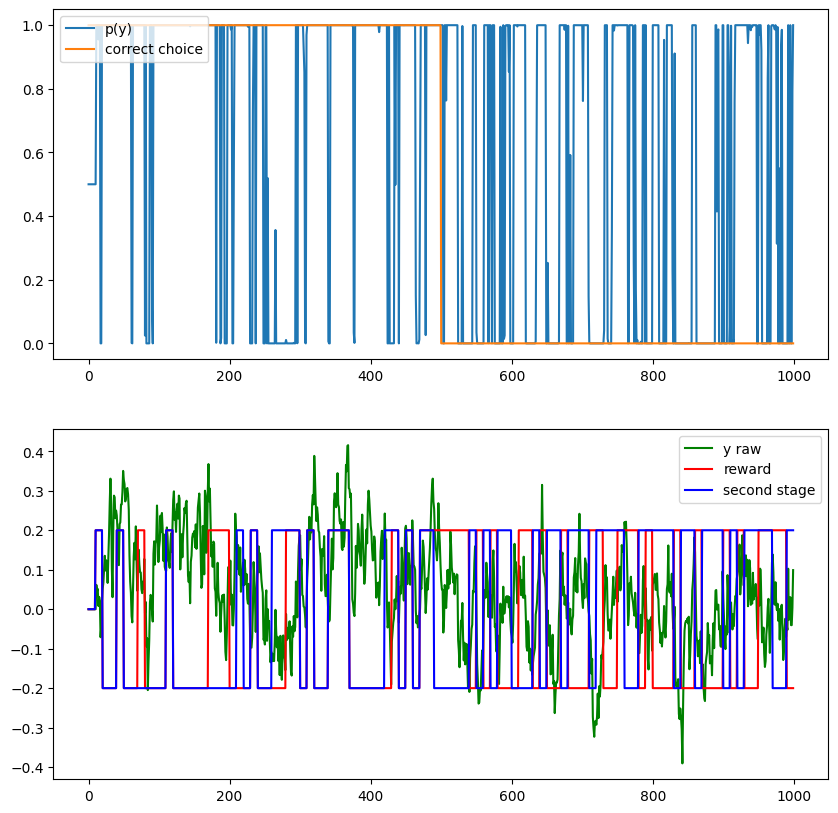

In [20]:
trial = 15
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
ax[0].plot(y[trial, :, 0].cpu().detach().numpy(), label = "p(y)")
ax[1].plot(y_raw[trial, :, 0].cpu().detach().numpy()/(max(y_raw[0, :, 0]) - min(y_raw[0, :, 0])).cpu().numpy(), label = "y raw", c = "g") 


ax[1].plot((inp[trial, :, 2].cpu().detach().numpy()) * 2, label = "reward", c = "r")
ax[1].plot((inp[trial, :, 1].cpu().detach().numpy()) * 2, label = "second stage", c = "b")
# plt.plot((i[0, :, 1].cpu().detach().numpy()) * 2, label = "S_S")

ax[0].plot(c[trial, :, 0].cpu().detach().numpy(), label = "correct choice")

ax[0].legend(loc = "upper left")
ax[1].legend()

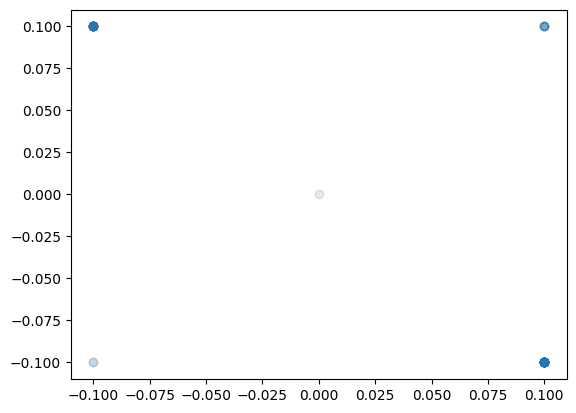

In [ ]:
plt.scatter(inp[0, :500, 0].cpu().detach().numpy(), inp[0, :500, 1].cpu().detach().numpy(), alpha=0.01)

In [2]:
# let's now convert these model results into training data useful for the RTRNNs 
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
ndt_mu = 300
ndt_s = 50 # these are all in ms
t_a = 0
t_b = 3
# lets say each trial is of 1500 ms, and in the model we only record activity from decision times
def convert_trials(y_raw, ndt_mu, ndt_s): 
    """we assign RT based on model output, which is discretised into 10 steps per trial and now stored in y_raw:

    Args: 
        y_raw (torch.tensor): model output, of shape (batch_size, seq_len, N)
    """
    # the logic is, based on the raw decision output curve sample a reaction time at which the decision is made. 
    # the decision should additionally be coherent to the last time step's decision. 
    # record 1 if the decision is from a positive y_raw, 0 otherwise
    # base this on standard deviations of all decision values
    batch_size, n_trials, N = y_raw.shape
    y_std = torch.std(y_raw)
    rt = torch.randn(batch_size, n_trials, device=y_raw.device) * ndt_s + ndt_mu
    choices = torch.zeros(batch_size, n_trials, device=y_raw.device)
    for i in range(batch_size):
        for j in range(n_trials):
            y_N = y_raw[i, j, :]
            choices[i, j] = 1 if y_N[-1] > 0 else 0
            for k in range(N):
                if torch.rand(1, device=y_raw.device) < abs(y_N[k])/y_std and torch.sign(y_N[k]) == torch.sign(y_N[-1]):
                    rt[i, j] += k * 1300/N
                    break
                if k == N - 1: 
                    rt[i, j] = torch.nan
            
    return (rt, choices)

def convert_inputs(input_raw, N = 10, seq_len = 100): 
    # Input raw is in the form of (batch_size, seq_len, 3) where the 3 are past_choice, reward, and second_stage
    input_raw = input_raw.reshape(-1, seq_len, N, 3).cpu().numpy()
    past_choice = []
    reward = []
    stage2 = []
    block = []
    for i in range(input_raw.shape[0]):
        for j in range(seq_len):
            past_choice.append(np.array(input_raw[i, j, 0, 0]>0, dtype = int))
            reward.append(np.array(input_raw[i, j, 0, 1]>0, dtype = int))
            stage2.append(np.array(input_raw[i, j, 0, 2]>0, dtype = int))
            block.append(i)
    cog_data = pd.DataFrame({"action": past_choice, "reward": reward, "stage2": stage2, "block": block})
    return cog_data

def get_dataloaders(cog_data, rt, choices, batch_size, device = "cuda", K_folds = 1, shuffle=True):
    input_data = np.zeros([rt.shape[0], rt.shape[1], 6])
    choice_data = np.zeros([rt.shape[0], rt.shape[1], 2])
    for i in range(rt.shape[0]):
        # input_data[i, :, 0] = np.concatenate((np.array([0]), np.array(cog_data["action"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 1] = np.concatenate((np.array([0]), np.array(cog_data["action"][cog_data.block == i])[:-1] == 1))
        # input_data[i, :, 2] = np.concatenate((np.array([0]), np.array(cog_data["reward"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 3] = np.concatenate((np.array([0]), np.array(cog_data["reward"][cog_data.block == i])[:-1] == 1))
        # input_data[i, :, 4] = np.concatenate((np.array([0]), np.array(cog_data["stage2"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 5] = np.concatenate((np.array([0]), np.array(cog_data["stage2"][cog_data.block == i])[:-1] == 1))
        input_data[i, :, 0] = np.array(cog_data["action"][cog_data.block == i]) == 0
        input_data[i, :, 1] = np.array(cog_data["action"][cog_data.block == i]) == 1
        input_data[i, :, 2] = np.array(cog_data["reward"][cog_data.block == i]) == 0
        input_data[i, :, 3] = np.array(cog_data["reward"][cog_data.block == i]) == 1
        input_data[i, :, 4] = np.array(cog_data["stage2"][cog_data.block == i]) == 0
        input_data[i, :, 5] = np.array(cog_data["stage2"][cog_data.block == i]) == 1

    choice_data[:, :, 0] = choices.cpu().numpy()
    choice_data[:, :, 1] = rt.cpu().numpy()
    train_dataset = CustomDataset(input_data[:int(0.8 * len(input_data)), ...], choice_data[:int(0.8 * len(choice_data)), ...], device = device)
    val_dataset = CustomDataset(input_data[int(0.8 * len(input_data)):, ...], choice_data[int(0.8 * len(choice_data)):, ...], device = device)
    # do K folds: 
    if K_folds > 1: 
        kf = KFold(n_splits=K_folds, shuffle = shuffle)
        splits = []
        for train_index, val_index in kf.split(input_data):
            train_dataset = CustomDataset(input_data[train_index, ...], choice_data[train_index, ...], device = device)
            val_dataset = CustomDataset(input_data[val_index, ...], choice_data[val_index, ...], device = device)
            splits.append((train_dataset, val_dataset))

        dataloaders = []
        for train_dataset, val_dataset in splits:
            dataloaders.append({
                "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle),
                "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            })
        return dataloaders
    else: 
        return {
            "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle),
            "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
        }

class CustomDataset(Dataset):
    def __init__(self, u, x, device = None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.x = torch.tensor(x, device = device)
        self.u = torch.tensor(u, device = device)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.u[idx], self.x[idx]


In [3]:
trial = 15
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

# ax[0].plot(y[trial, :, 0].cpu().detach().numpy(), label = "p(y)")

ax[0].plot(choice_rt[trial, :].cpu().detach().numpy()/1300 + 0.5, label = "choice * rt")
ax[1].plot(y_raw[trial, :, 0].cpu().detach().numpy()/(max(y_raw[0, :, 0]) - min(y_raw[0, :, 0])).cpu().numpy(), label = "y raw", c = "g") 
ax[0].plot(y_raw[trial, :, 0].cpu().detach().numpy()/(max(y_raw[0, :, 0]) - min(y_raw[0, :, 0])).cpu().numpy() + 0.5, label = "y raw", c = "g") 

ax[1].plot((inp[trial, :, 2].cpu().detach().numpy()) * 2, label = "reward", c = "r")
# plt.plot((i[0, :, 1].cpu().detach().numpy()) * 2, label = "S_S")

ax[0].plot(c[trial, :, 0].cpu().detach().numpy(), label = "correct choice")

ax[0].legend(loc = "upper left")
ax[1].legend()

NameError: name 'plt' is not defined

In [4]:
from Network_models.Trainer import RTRNNTrainer

In [5]:
# RTRNN training on the data!
batch_size = 20
out_distribution = False
configs = {
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": LOG_PATH,
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "RTRNN", 
        "model_path": "Network_models.RTRNN",
        "model_params":{
            "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
            "cell_type":"GRU", "trial_output_hidden": 1, "trial_output_hidden_size": [16,], # if want hidden output layers (deep output, then give a list)
            "trial_output_hidden_nonlinearities": ["ReLU"], 
            "last_step": False, # use only the last step of the decision RNN trajectory per trial
            "pad_zeros":0, # i .* [1, 0, ,...] (if pad_zeros) or [1, 1, 1,...] 
            "trial_interpolation": True,  # add an additional input channel indicating a 0 to 1 linspace for each trial
            "noisy": False, # add noise to hidden states
            "out_distribution": out_distribution, # output a parametrization of the distribution of the choice and RT as a mixed Gaussian (for now) and note the tau length scale is defined in the loss function.  
        },
    },
    "rt_dist_specs": {
        "dist_name": 'gaussian' if out_distribution else None,
    }, 
    "rt_weight" : 0.01, 
    "device": "cuda", 
    # "scheduler": False, 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "training_config": {
        "batch_size": 256, 
        "val_ratio": 0.2, 
        "n_trials": 10, 
    }, 
}
rtrnn_trainer = RTRNNTrainer(configs)


In [6]:
y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
rt, choices = convert_trials(y_raw, ndt_mu, ndt_s)
rt = rt/1500
y_raw = y_raw.reshape(y_raw.shape[0], -1, 1)
cog_data = convert_inputs(inp)
dataloaders_train = get_dataloaders(cog_data, rt, choices, batch_size, device = "cuda", K_folds = 5)

NameError: name 'y_raw' is not defined

In [7]:
dataloaders_train = torch.load(MODEL_SAVE_PATH/ "dataloaders.pth")

NameError: name 'torch' is not defined

In [73]:
import shutil
hidden_size = 4
zero_padding = 0
rt_weight = 0.5
cell_type = "GRU"
interpolate = True
out_distribution = True
best_split_losses = {}
from Network_models.Trainer import RTRNNTrainer
for recurrence_per_trial in [4]: 
    best_split_losses[f"N={recurrence_per_trial}"] = {}
    best_split_losses[f"N={recurrence_per_trial}"]["best_split"] = None
    best_split_losses[f"N={recurrence_per_trial}"]["best_loss"] = np.inf
    configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
    configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
    configs["model_specs"]["model_params"]["recurrence_per_trial"] = recurrence_per_trial
    configs["model_specs"]["model_params"]["cell_type"] = cell_type
    configs["model_specs"]["model_params"]["trial_interpolation"] = interpolate

    configs["rt_weight"] = rt_weight
    rtrnn_trainer = RTRNNTrainer(configs)
    model_name = f"ISNNet_{cell_type}_HS={hidden_size}_N={recurrence_per_trial}_ZP{zero_padding}_rtw{rt_weight}_output_hidden_16{"_out_dist" if out_distribution else ""}{"_interpolate" if interpolate else ""}"
    for dirs in [configs["save_path"], configs["check_path"], configs["log_path"]]:
        path = dirs / model_name
        if not os.path.exists(path):
            os.makedirs(path)
        else: 
            shutil.rmtree(path)
            os.makedirs(path)
        for split in range(5): 
            split_path = path / f"split_{split}"
            if not os.path.exists(split_path):
                os.makedirs(split_path)
        
    for split in range(1): 
        rtrnn_trainer = RTRNNTrainer(configs)
        rtrnn_trainer.train(
            dataloaders_train[split]["train"],
            dataloaders_train[split]["val"],
            epochs = 3000,
            save_interval = 500,
            reset_interval = 10000,
            save_path = configs["save_path"] / model_name / f"split_{split}" / "model.pth",
            check_path = configs["check_path"] / model_name / f"split_{split}",
            log_path = configs["log_path"] / model_name / f"split_{split}",
            early_stop = 100,
        )
        best_split_losses[f"N={recurrence_per_trial}"][f"split_{split}"] = rtrnn_trainer.best_val_loss_split
        if rtrnn_trainer.best_val_loss_split < best_split_losses[f"N={recurrence_per_trial}"]["best_loss"]:
            best_split_losses[f"N={recurrence_per_trial}"]["best_loss"] = rtrnn_trainer.best_val_loss_split
            best_split_losses[f"N={recurrence_per_trial}"]["best_split"] = split
    
    

tensor(0.8552, device='cuda:0')
tensor(0.7850, device='cuda:0')
tensor(0.6938, device='cuda:0')
tensor(0.6054, device='cuda:0')
tensor(0.5536, device='cuda:0')
tensor(0.5066, device='cuda:0')
tensor(0.4666, device='cuda:0')
tensor(0.4407, device='cuda:0')
tensor(0.4251, device='cuda:0')
tensor(0.4146, device='cuda:0')
tensor(0.4075, device='cuda:0')
tensor(0.4028, device='cuda:0')
tensor(0.4004, device='cuda:0')
tensor(0.3985, device='cuda:0')
tensor(0.3969, device='cuda:0')
tensor(0.3958, device='cuda:0')
tensor(0.3953, device='cuda:0')
tensor(0.3947, device='cuda:0')
tensor(0.3946, device='cuda:0')
tensor(0.3941, device='cuda:0')
tensor(0.3937, device='cuda:0')
tensor(0.3933, device='cuda:0')
tensor(0.3931, device='cuda:0')
tensor(0.3927, device='cuda:0')
tensor(0.3927, device='cuda:0')
tensor(0.3925, device='cuda:0')
tensor(0.3930, device='cuda:0')
tensor(0.3929, device='cuda:0')
tensor(0.3923, device='cuda:0')
tensor(0.3918, device='cuda:0')
tensor(0.3922, device='cuda:0')
tensor(0

KeyboardInterrupt: 

In [74]:
rtrnn_trainer.save_model(MODEL_SAVE_PATH / model_name / "split_0/model.pth")

In [70]:

rtrnn_trainer.load_model(configs["save_path"] / model_name / f"split_{split}" / "model.pth")

FileNotFoundError: [Errno 2] No such file or directory: '../../saved_models/ISNNet_GRU_HS=4_N=4_ZP0_rtw0.5_output_hidden_16_interpolate/split_0/model.pth'

In [239]:
torch.save(dataloaders, MODEL_SAVE_PATH / "dataloaders.pth")

In [32]:
y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
rt, choices = convert_trials(y_raw, ndt_mu, ndt_s)
rt = rt/1500
cog_data = convert_inputs(inp)
dataloaders_test = get_dataloaders(cog_data, rt, choices, batch_size, device = "cuda", K_folds = 1, shuffle=False)
torch.save(dataloaders_test, MODEL_SAVE_PATH / "dataloaders_test.pth")
torch.save(y_raw, MODEL_SAVE_PATH / "y_raw_test.pth")

In [33]:
from CustomMapper.CustomMapper import CustomDataset
import plotly.express as px
dataloaders_test = torch.load(MODEL_SAVE_PATH / "dataloaders_test.pth")
y_raw = torch.load(MODEL_SAVE_PATH / "y_raw_test.pth")

In [22]:
best_split_losses_archive = {
    "N=1": {
        "best_split": 1,
        "best_loss": torch.tensor(0.4738, device="cuda:0"),
        "split_0": torch.tensor(0.4827, device="cuda:0"),
        "split_1": torch.tensor(0.4851, device="cuda:0"),
        "split_2": torch.tensor(0.4859, device="cuda:0"),
        "split_3": torch.tensor(0.4738, device="cuda:0"),
        "split_4": torch.tensor(0.4746, device="cuda:0"),
    },
    "N=2": {
        "best_split": 1,
        "best_loss": torch.tensor(0.3186, device="cuda:0"),
        "split_0": torch.tensor(0.3186, device="cuda:0"),
        "split_1": torch.tensor(0.3788, device="cuda:0"),
        "split_2": torch.tensor(0.3538, device="cuda:0"),
        "split_3": torch.tensor(0.3206, device="cuda:0"),
        "split_4": torch.tensor(0.3471, device="cuda:0"),
    },
    "N=3": {
        "best_split": 1,
        "best_loss": torch.tensor(0.3843, device="cuda:0"),
        "split_0": torch.tensor(0.4234, device="cuda:0"),
        "split_1": torch.tensor(0.4115, device="cuda:0"),
        "split_2": torch.tensor(0.4181, device="cuda:0"),
        "split_3": torch.tensor(0.4179, device="cuda:0"),
        "split_4": torch.tensor(0.3843, device="cuda:0"),
    },
    "N=4": {
        "best_split": 1,
        "best_loss": torch.tensor(0.4065, device="cuda:0"),
        "split_0": torch.tensor(0.4657, device="cuda:0"),
        "split_1": torch.tensor(0.4442, device="cuda:0"),
        "split_2": torch.tensor(0.4826, device="cuda:0"),
        "split_3": torch.tensor(0.4503, device="cuda:0"),
        "split_4": torch.tensor(0.4065, device="cuda:0"),
    },
}

In [58]:
def visualize_model_performance(rtrnn_trainer_test, dataloaders, y_raw, plot_index = 0):
    u, x = next(iter(dataloaders[0]["val"])) if type(dataloaders) == list else next(iter(dataloaders["val"]))
    with torch.no_grad():
        u = u.to(rtrnn_trainer_test.device).float()
        h, out = rtrnn_trainer_test.model.show(u)
    recurrence_per_trial_test = rtrnn_trainer_test.model.recurrence_per_trial
    out_distribution = rtrnn_trainer_test.model.out_distribution

    # scatter plot with line connecting each point
    lines = pd.DataFrame(h[0, :, :8].cpu().numpy())
    x = np.linspace(0, recurrence_per_trial_test * 100 - 1, recurrence_per_trial_test * 100)
    lines["x"] = x
    lines = lines.melt(id_vars="x", var_name="h_dim", value_name="h_value")
    p1 = px.line(lines, x="x", y="h_value", color="h_dim")

    block_id = plot_index
    choices = pd.DataFrame(out[block_id, :, :].cpu().numpy())
    if out_distribution:
        choices.columns = ["predicted_rt1", "predicted_rt2", 'predicted_choice_1', "predicted_choice_2"]
        choices["predicted_rt1"] = np.log(choices["predicted_rt1"])
        choices["predicted_rt2"] = np.log(choices["predicted_rt2"])
        choices['predicted_rt'] = np.take_along_axis(np.array((choices[["predicted_rt1", "predicted_rt2"]])), np.array(choices["predicted_choice_2"]>choices["predicted_choice_1"], dtype = int).reshape(-1, 1), axis = -1)

        x = np.linspace(0, 99, 100)

        choices["x"] = x
        choices["true_choice"] = (
            dataloaders[0]["val"].dataset.x[block_id, :, 0].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
        )
        y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
        true_z = y_raw[-len(dataloaders[0]["val"].dataset.x):][block_id, :, -1].cpu().numpy() if type(dataloaders) == list else y_raw[-len(dataloaders["val"].dataset.x):][block_id, :, -1].cpu().numpy()
        true_z = (true_z - min(true_z)) / (max(true_z) - min(true_z))
        choices["true_z"] = (
            true_z
        )
        choices["true_rt (log)"] = np.log(
            dataloaders[0]["val"].dataset.x[block_id, :, 1].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy()
        )

        choices = choices[[
            "predicted_choice_2", "predicted_rt", "true_choice", "true_z", "true_rt (log)", "x"
        ]]
        choices = choices.melt(id_vars="x", var_name="choice", value_name="choice_value")
    else:
        choices.columns = ["predicted_choice", "predicted_rt (log)"]

        x = np.linspace(0, 99, 100)

        choices["x"] = x
        choices["true_choice"] = (
            dataloaders[0]["val"].dataset.x[block_id, :, 0].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
        )
        y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
        true_z = y_raw[-len(dataloaders[0]["val"].dataset.x):][block_id, :, -1].cpu().numpy() if type(dataloaders) == list else y_raw[-len(dataloaders["val"].dataset.x):][block_id, :, -1].cpu().numpy()
        true_z = (true_z - min(true_z)) / (max(true_z) - min(true_z))
        choices["true_z"] = (
            true_z
        )

        choices["true_rt (log)"] = np.log(
            dataloaders[0]["val"].dataset.x[block_id, :, 1].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy()
        )

        choices = choices.melt(id_vars="x", var_name="choice", value_name="choice_value")
    p2 = px.line(choices, x="x", y="choice_value", color="choice")
    p1.show(), p2.show()

In [72]:
recurrence_per_trial_test = 4
hidden_size = 4
zero_padding = 0
rt_weight = 0.5
out_distribution = False
interpolate = True

cell_type = "GRU"
# best_split = best_split_losses[f'N={recurrence_per_trial_test}']["best_split"] if recurrence_per_trial_test != 1 else 0
best_split = 0
# print(f"best split for N={recurrence_per_trial_test} is {best_split}")
configs["model_specs"]["model_params"][
    "recurrence_per_trial"
] = recurrence_per_trial_test
configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
configs["model_specs"]["model_params"]["cell_type"] = cell_type
configs["rt_weight"] = rt_weight
configs["model_specs"]["model_params"]["trial_interpolation"] = interpolate

rtrnn_trainer_test = RTRNNTrainer(configs)
u = dataloaders_test[0]["val"].dataset.u if type(dataloaders_test) == list else dataloaders_test["val"].dataset.u
ref = dataloaders_test[0]["val"].dataset.x if type(dataloaders_test) == list else dataloaders_test["val"].dataset.x

rtrnn_trainer_test.load_model(
    configs["save_path"]
    / (f"ISNNet_{cell_type}_HS={hidden_size}_N={recurrence_per_trial_test}_ZP{zero_padding}_rtw{rt_weight}_output_hidden_16" + ("_out_dist" if out_distribution else "") + "_interpolate" if interpolate else "")
    / f"split_{best_split}"
    / "model.pth"
)
rtrnn_trainer_test.model.eval()
visualize_model_performance(rtrnn_trainer_test, dataloaders_test, y_raw, plot_index=0)


In [ ]:
recurrence_per_trial_test = 4
hidden_size = 4
zero_padding = 0
rt_weight = 0.5
out_distribution = True
interpolate = True

cell_type = "GRU"
# best_split = best_split_losses[f'N={recurrence_per_trial_test}']["best_split"] if recurrence_per_trial_test != 1 else 0
best_split = 0
# print(f"best split for N={recurrence_per_trial_test} is {best_split}")
configs["model_specs"]["model_params"][
    "recurrence_per_trial"
] = recurrence_per_trial_test
configs["model_specs"]["model_params"]["hidden_size"] = hidden_size
configs["model_specs"]["model_params"]["pad_zeros"] = zero_padding
configs["model_specs"]["model_params"]["cell_type"] = cell_type
configs["rt_weight"] = rt_weight
configs["model_specs"]["model_params"]["trial_interpolation"] = interpolate

rtrnn_trainer_test = RTRNNTrainer(configs)
u = dataloaders_test[0]["val"].dataset.u if type(dataloaders_test) == list else dataloaders_test["val"].dataset.u
ref = dataloaders_test[0]["val"].dataset.x if type(dataloaders_test) == list else dataloaders_test["val"].dataset.x

rtrnn_trainer_test.load_model(
    configs["save_path"]
    / (f"ISNNet_{cell_type}_HS={hidden_size}_N={recurrence_per_trial_test}_ZP{zero_padding}_rtw{rt_weight}_output_hidden_16" + ("_out_dist" if out_distribution else "") + ("_interpolate" if interpolate else ""))
    / f"split_{best_split}"
    / "model.pth"
)
rtrnn_trainer_test.model.eval()
visualize_model_performance(rtrnn_trainer_test, dataloaders_test, y_raw, plot_index=0)


In [67]:
configs['save_path']

PosixPath('../../saved_models')

In [140]:
recurrence_per_trial_test = configs['model_specs']['model_params']["recurrence_per_trial"]
hidden_size = configs["model_specs"]["model_params"]["hidden_size"]
zero_padding = configs["model_specs"]['model_params']['pad_zeros']

rtrnn_trainer_test = rtrnn_trainer
u = dataloaders[0]["val"].dataset.u if type(dataloaders) == list else dataloaders["val"].dataset.u
ref = dataloaders[0]["val"].dataset.x if type(dataloaders) == list else dataloaders["val"].dataset.x

rtrnn_trainer_test.model.eval()
with torch.no_grad():
    u = u.to(rtrnn_trainer_test.device).float()
    h, out = rtrnn_trainer_test.model.show(u)
recurrence = recurrence_per_trial_test
import plotly.express as px

# scatter plot with line connecting each point
lines = pd.DataFrame(h[0, :, :8].cpu().numpy())
x = np.linspace(0, recurrence_per_trial_test * 100 - 1, recurrence_per_trial_test * 100)
lines["x"] = x
lines = lines.melt(id_vars="x", var_name="h_dim", value_name="h_value")
p1 = px.line(lines, x="x", y="h_value", color="h_dim")

block_id = np.random.randint(0, 100)
choices = pd.DataFrame(out[block_id, :, :].cpu().numpy())
x = np.linspace(0, 99, 100)

choices["x"] = x
choices["true_choice"] = (
    dataloaders[0]["val"].dataset.x[block_id, :, 0].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
)
y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
true_z = y_raw[-len(dataloaders[0]["val"].dataset.x):][block_id, :, -1].cpu().numpy() if type(dataloaders) == list else y_raw[-len(dataloaders["val"].dataset.x):][block_id, :, -1].cpu().numpy()
true_z = (true_z - min(true_z)) / (max(true_z) - min(true_z))
choices["true_z"] = (
    true_z
)
# choices["true_choice"] = (
#     torch.cat(
#         [
#             torch.zeros(1, device="cuda"),
#             dataloaders[best_split]["val"].dataset.x[block_id, :-1, 0] if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :-1, 0]
#         ]
#     )
#     .cpu()
#     .numpy()
# )
# choices["true_z"] = (
#     torch.cat(
#         [
#             torch.zeros(1, device="cuda"),
#             torch.tensor(true_z[:-1], device="cuda"),
#         ]
#     ).cpu().numpy()
# )

# true_z = -np.array([list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][0] -  list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][1] for i in range(100)])
# true_z = (true_z - min(true_z))/(max(true_z) - min(true_z))
# choices["true_z"] = true_z0
choices["true_rt (log)"] = np.log(
    dataloaders[0]["val"].dataset.x[block_id, :, 1].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy()
)
# true_median_rt = experiment.cog_data["median_RTs"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id]
# choices["true_median_rt (log)"] = np.array(np.log(true_median_rt))

choices = choices[[
    "predicted_choice_2", "predicted_rt", "true_choice", "true_z", "true_rt (log)", "x"
]]
choices = choices.melt(id_vars="x", var_name="choice", value_name="choice_value")
p2 = px.line(choices, x="x", y="choice_value", color="choice")
p1.show(), p2.show()

(None, None)

In [160]:
dataloaders = dataloaders_test
recurrence_per_trial_test = configs['model_specs']['model_params']["recurrence_per_trial"]
hidden_size = configs["model_specs"]["model_params"]["hidden_size"]
zero_padding = configs["model_specs"]['model_params']['pad_zeros']

rtrnn_trainer_test = rtrnn_trainer
u = dataloaders[0]["val"].dataset.u if type(dataloaders) == list else dataloaders["val"].dataset.u
ref = dataloaders[0]["val"].dataset.x if type(dataloaders) == list else dataloaders["val"].dataset.x

rtrnn_trainer_test.model.eval()
with torch.no_grad():
    u = u.to(rtrnn_trainer_test.device).float()
    h, out = rtrnn_trainer_test.model.show(u)
recurrence = recurrence_per_trial_test
import plotly.express as px

# scatter plot with line connecting each point
lines = pd.DataFrame(h[0, :, :8].cpu().numpy())
x = np.linspace(0, recurrence_per_trial_test * 100 - 1, recurrence_per_trial_test * 100)
lines["x"] = x
lines = lines.melt(id_vars="x", var_name="h_dim", value_name="h_value")
p1 = px.line(lines, x="x", y="h_value", color="h_dim")

block_id = np.random.randint(0, 100)
block_id = 5
choices = pd.DataFrame(out[block_id, :, :].cpu().numpy())
choices.columns = ["predicted_rt1", "predicted_rt2", 'predicted_choice_1', "predicted_choice_2"]
choices["predicted_rt1"] = np.log(choices["predicted_rt1"])
choices["predicted_rt2"] = np.log(choices["predicted_rt2"])
choices['predicted_rt'] = np.take_along_axis(np.array((choices[["predicted_rt1", "predicted_rt2"]])), np.array(choices["predicted_choice_2"]>choices["predicted_choice_1"], dtype = int).reshape(-1, 1), axis = -1)
x = np.linspace(0, 99, 100)

choices["x"] = x
choices["true_choice"] = (
    dataloaders[0]["val"].dataset.x[block_id, :, 0].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 0].cpu().numpy()
)
y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
true_z = y_raw[-len(dataloaders[0]["val"].dataset.x):][block_id, :, -1].cpu().numpy() if type(dataloaders) == list else y_raw[-len(dataloaders["val"].dataset.x):][block_id, :, -1].cpu().numpy()
true_z = (true_z - min(true_z)) / (max(true_z) - min(true_z))
choices["true_z"] = (
    true_z
)
# choices["true_choice"] = (
#     torch.cat(
#         [
#             torch.zeros(1, device="cuda"),
#             dataloaders[best_split]["val"].dataset.x[block_id, :-1, 0] if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :-1, 0]
#         ]
#     )
#     .cpu()
#     .numpy()
# )
# choices["true_z"] = (
#     torch.cat(
#         [
#             torch.zeros(1, device="cuda"),
#             torch.tensor(true_z[:-1], device="cuda"),
#         ]
#     ).cpu().numpy()
# )

# true_z = -np.array([list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][0] -  list(experiment.cog_data["score"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id])[i][1] for i in range(100)])
# true_z = (true_z - min(true_z))/(max(true_z) - min(true_z))
# choices["true_z"] = true_z0
choices["true_rt (log)"] = np.log(
    dataloaders[0]["val"].dataset.x[block_id, :, 1].cpu().numpy() if type(dataloaders) == list else dataloaders["val"].dataset.x[block_id, :, 1].cpu().numpy()
)
# true_median_rt = experiment.cog_data["median_RTs"][experiment.cog_data["block"] == len(experiment.dataloaders["train"].dataset) + block_id]
# choices["true_median_rt (log)"] = np.array(np.log(true_median_rt))

choices = choices[[
    "predicted_choice_2", "predicted_rt", "true_choice", "true_z", "true_rt (log)", "x"
]]
choices = choices.melt(id_vars="x", var_name="choice", value_name="choice_value")
p2 = px.line(choices, x="x", y="choice_value", color="choice")
p1.show(), p2.show()

(None, None)

In [76]:
u = dataloaders_test["val"].dataset.u
y = dataloaders_test['val'].dataset.x


In [80]:
y.shape

torch.Size([200, 100, 2])

In [92]:
sample_results = torch.randn([200, 100, 4]).to(y.device)
print(sample_results)
indices = y[:, :, 0].long().unsqueeze(-1)#.expand(-1, -1, sample_results.size(-1))
selected_results = sample_results.gather(-1, indices).squeeze(-1)
print(selected_results.shape)

tensor([[[-0.2714, -0.1545,  1.0438, -0.1778],
         [-0.7220, -0.7369, -0.6534, -0.2556],
         [ 0.7177, -1.0062, -0.6843,  0.2412],
         ...,
         [ 0.5491,  2.0615,  1.5923,  0.6879],
         [ 0.9250,  0.1713, -0.1794, -0.7075],
         [-1.0390, -0.1042, -1.0984, -1.7137]],

        [[-0.2290,  0.4285,  0.9197,  0.0752],
         [-0.4919,  0.2790, -0.1015, -0.4014],
         [ 1.1126, -0.8758,  0.5395, -0.5570],
         ...,
         [ 0.5669, -0.2835,  0.1489,  0.0462],
         [ 1.7745, -2.0760,  0.7147, -1.1565],
         [ 0.9723,  0.8622, -1.3664,  0.6487]],

        [[-0.0147, -0.5063,  0.0977, -0.7066],
         [-1.1696,  0.8032,  0.7317,  1.1945],
         [ 0.1951, -0.1589,  1.0195,  0.7465],
         ...,
         [-1.4801, -0.4479, -0.4292,  0.0161],
         [-0.4249,  0.5279,  1.8833,  0.8406],
         [ 0.2963,  0.3783,  1.0245, -1.0716]],

        ...,

        [[ 1.3647, -0.0053, -0.5465,  1.2157],
         [-1.3463,  1.1939, -0.0357,  0.2559]

In [98]:
torch.nn.MSELoss(reduction = "none")(y[:, :, 0], selected_results).mean()

tensor(1.4985, device='cuda:0', dtype=torch.float64)

In [59]:
u_ = rtrnn_trainer_test.model.transform_input(u)
u_.shape

torch.Size([200, 100, 2, 6])


torch.Size([200, 200, 6])

In [ ]:
u_ = u_.reshape(200, 100, 2, 6)

In [66]:
u_[0, 0:10, :, :]

tensor([[[1., 0., 1., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 1., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 1., 0., 1.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [73]:
t = torch.linspace(0, 1, 2).reshape(1, 1, 2, 1).repeat(*u_.shape[0:2], 1, 1)

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [72]:
torch.cat([u_.cpu(), t.cpu()], dim = -1).shape

torch.Size([200, 100, 2, 7])

In [1]:
import plotly.express as px
trial = 1 
px.line(y_raw[trial, :, 0].cpu().detach().numpy())#), label = "p(y)") 

# px.line((c[trial, :, 0].cpu().detach().numpy() - 0.5) * 100)#, label = "correct choice")

NameError: name 'y_raw' is not defined

trained performance 57.81999969482422
random performance 50.13999938964844


([<matplotlib.axis.XTick at 0x7a74215483e0>,
 [Text(0, 0, 'model'), Text(1, 0, 'random')])

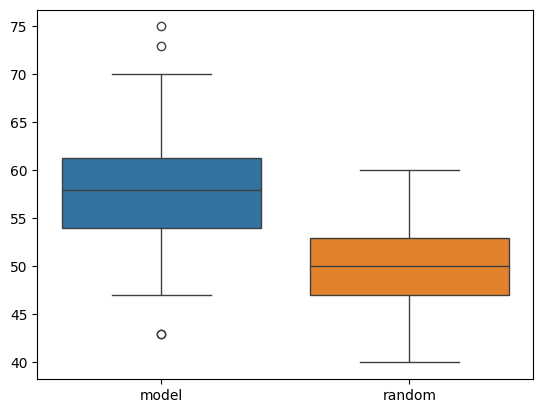

In [215]:
perf_model = sum(out.T).cpu().numpy()
perf_random = sum(out_2.T).cpu().numpy()
print(f"trained performance {perf_model.mean()}")
print(f"random performance {perf_random.mean()}")
import seaborn as sns
sns.boxplot(data = [perf_model, perf_random])
# add labels
plt.xticks(ticks = [0, 1], labels = ["model", "random"])

# Exploration of how to use variational inference to brute force a mixture-of-exGaussian fit to DDM parameters.
- model I want: from DDM parameters to several parameters of the exGaussian:

from: 
- v: drift rate (= (strength A - strength B) * drift_scale + bias)
- NDT_s, NDT_mu: nondecision time (mean and standard deviation)
- T_dur: duration of the trial
     

to: 
- p, specifying the total probability of choosing response A
- mu_1, mu_2: means of the two Gaussian components of the exGaussians
- sigma_1, sigma_2: standard deviations of the two Gaussian components of the exGaussians
- tau_1, tau_2: means of the exponential components of the exGaussians



In [16]:
# First, define a generative process for the data, based on PyDDM
import pyddm
class RT_Gen:
    def __init__(self):
        self.dt = 0.02
        self.rt_model = None 
    
    def sample_ddm(self, v, ndt_mu, ndt_s):
        pass

rt_model = pyddm.ddm

AttributeError: module 'pyddm' has no attribute 'ddm'

# Exploration of simulated dataset

## Plot RTs

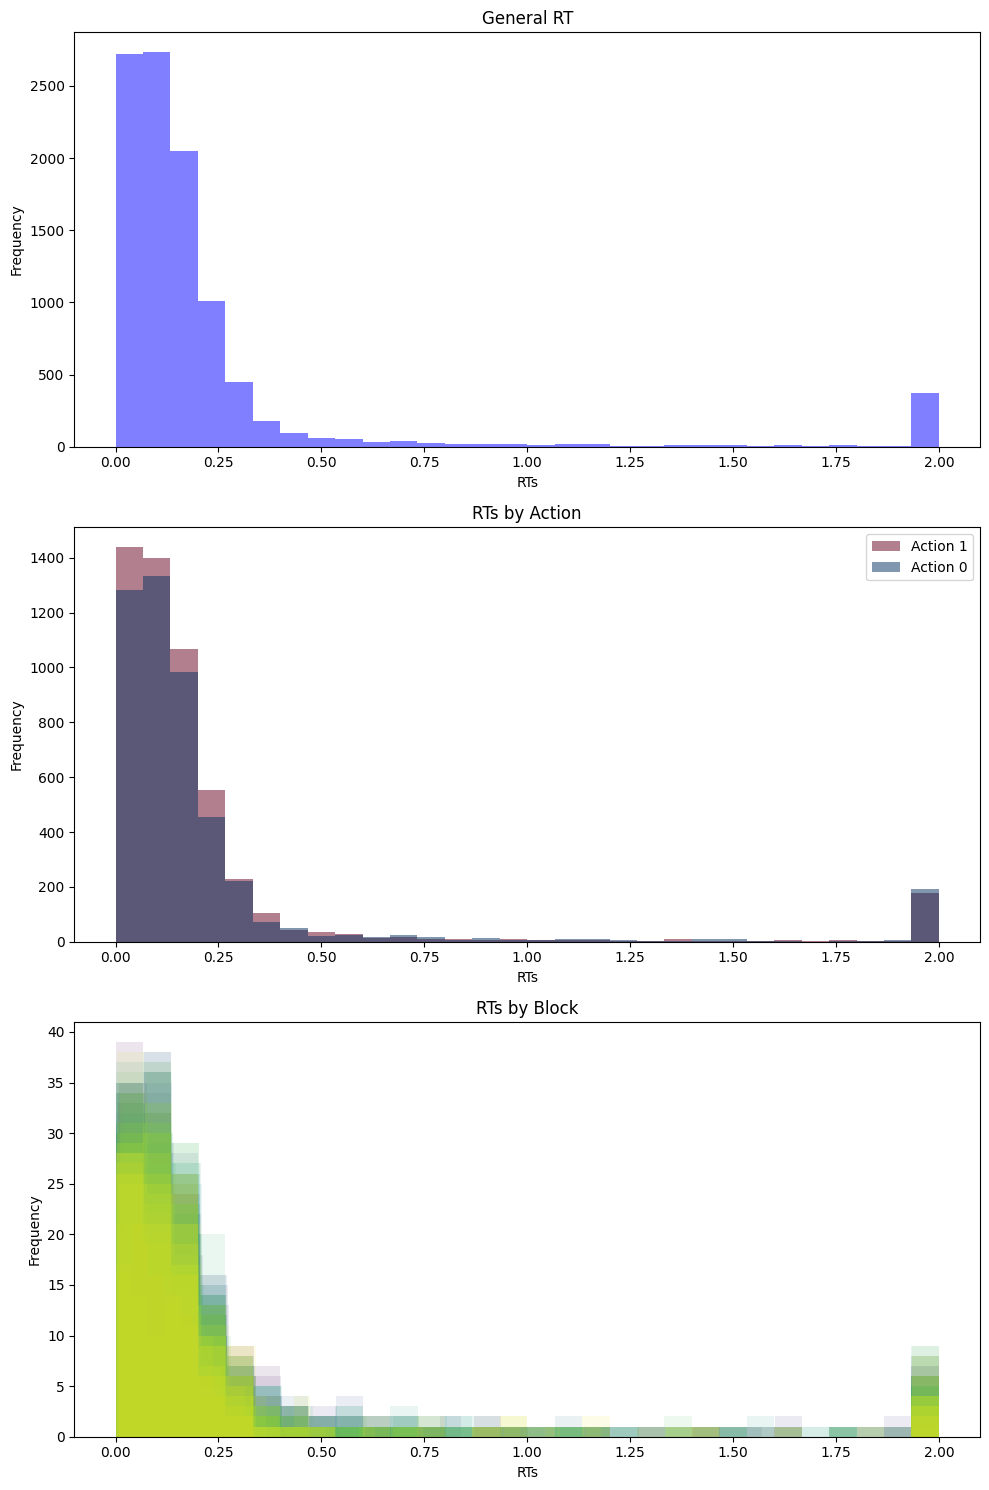

In [ ]:
import matplotlib as mpl
simulated_dataset = experiment.cog_data
simulated_dataset.RTs = [min(2, x) for x in simulated_dataset.RTs] 
# Explore simulated RT profile
fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Create 3 subplots vertically aligned

# Plot 1: General RT
ax[0].hist(simulated_dataset['RTs'], bins=30, color='blue', alpha=0.5)
ax[0].set_title('General RT')
ax[0].set_xlabel('RTs')
ax[0].set_ylabel('Frequency')

color_map_action = mpl.colormaps["RdBu"]
# Plot 2: RTs for each action
for i, action in enumerate(simulated_dataset['action'].unique()):
    subset = simulated_dataset[simulated_dataset['action'] == action]
    ax[1].hist(subset['RTs'], bins=30, alpha=0.5, color=color_map_action(int(i * 256)), label=f'Action {action}')
ax[1].set_title('RTs by Action')
ax[1].set_xlabel('RTs')
ax[1].set_ylabel('Frequency')
ax[1].legend()

color_map_block = mpl.colormaps["viridis"]
# Plot 3: RTs for each block
for i, block in enumerate(simulated_dataset['block'].unique()):
    subset = simulated_dataset[simulated_dataset['block'] == block]
    ax[2].hist(subset['RTs'], bins=30, alpha=0.1, color=color_map_block(int(i * 256/(len(simulated_dataset['block'].unique
                                                                                         ())-1))),
               label=f'Block {block}')
ax[2].set_title('RTs by Block')
ax[2].set_xlabel('RTs')
ax[2].set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()